# Data preparation

## Keyword Vectorizer

In [1]:
from sentence_transformers import SentenceTransformer

import pandas as pd
import numpy as np
import os

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding

from sklearn.metrics import accuracy_score
from collections import Counter

import torch
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit

from tensorflow import keras
#from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

import ast
import networkx as nx
import itertools
import math
import warnings
import joblib

warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, StratifiedKFold
from sklearn.compose import make_column_transformer
from tqdm import tqdm
import xgboost as xgb

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, 
                             RocCurveDisplay, auc, precision_recall_curve, PrecisionRecallDisplay, precision_score, recall_score)

RANDOM_SEED = 42

In [2]:
class Graph(sg.core.graph.StellarGraph):
    
    def __init__(self, weighted = False, directed = False, dichot = False, lang = "en"):
        super().__init__()
        self.weighted = weighted
        self.directed = directed
        self.dichot = dichot
        self.lang = lang
    
        
    def from_mat(self, df, node_prop = 0.5):
        if self.lang == 'ko': #키워드가 한국어일 때
            encoder = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
        elif self.lang == 'en': #키워드가 영어일 때
            encoder = SentenceTransformer('all-MiniLM-L6-v2')
        
        feat_mat = pd.DataFrame(map(encoder.encode, df.index), index=df.index)
        num_all_nodes = len(feat_mat) #전체 노드 수
        prev_cutoff = 0
        
#         if self.weighted == True: # 가중치가 있는 경우
#             if self.dichot == True: # 가중치를 사용하여 이분화하는 경우
#                 #cutoff를 0부터 조금씩 높여가며 남은 노드의 비율에 맞추어 조정
#                 for i in tqdm(range(201)):
#                     cutoff = 5*i/1000
#                     temp = df.copy()
#                     temp = temp.applymap(lambda x : 1 if x > cutoff else 0)
#                     temp = temp.loc[(temp!=0).any(axis=1)]
#                     temp = temp.loc[:, (temp!=0).any(axis=0)]
#                     temp_G = super().from_networkx(nx.from_pandas_adjacency(temp))
#                     nodes = next(temp_G.connected_components())
                    
#                     if (len(nodes)/ num_all_nodes) < node_prop : 
#                         # (현재 노드/전체 노드)이 특정 비율 미만일 때
#                         temp = df.copy()
#                         temp = temp.applymap(lambda x : 1 if x > prev_cutoff else 0)
#                         temp = temp.loc[(temp!=0).any(axis=1)]
#                         temp = temp.loc[:, (temp!=0).any(axis=0)]
#                         print("남은 노드의 비율은 "+ str(round(prev_len_nodes/ num_all_nodes,4)*int(100)) + "% 입니다.")
#                         print("사용한 cutoff 값은 "+ str(prev_cutoff) + "입니다.\n")
#                         break
                        
#                     prev_len_nodes = len(nodes)    
#                     prev_cutoff = cutoff
                    
#                 df = temp.copy()
#                 feat_mat = feat_mat.loc[df.columns]
#             else : # 이분화하지 않고 가중치를 그대로 사용하는 경우
#                 pass
#         else: # 가중치가 없는 경우
#             df = df.applymap(lambda x : 1 if x >= 1 else 0)
                
#         for i in df.index:
#             df[i][i] = 0
            
        adj_mat = df
        G = super().from_networkx(nx.from_pandas_adjacency(adj_mat), node_features = feat_mat)
        nodes = next(G.connected_components()) #Giant component 추출
        G = G.subgraph(nodes)
        df = df.loc[G.nodes(),G.nodes()]
        print(G.info())
        
        return G, df

In [3]:
# 형식에 맞는 데이터 파일 불러오기
def load_data(file_path):
    if file_path.endswith(".csv"):
        edge = pd.read_csv(file_path)
        if 'Source' in edge.columns: #Edge table 형식으로 input을 넣은 경우
            square_edges = pd.DataFrame(
                {"source": edge['Source'], "target": edge['Target']})
            G = sg.core.graph.StellarGraph(edges=square_edges)
            data = nx.to_pandas_adjacency(G.to_networkx())
        else: #adjacency matrix 형태로 넣은 경우
            data = pd.read_csv(file_path, index_col = 0)
            #data = data * 500 #rescaling #data를 rescaling 해야 한다면 사용할 수 있음
            
    elif file_path.endswith(".xlsx"): #필요에 따라 위와 같이 수정하면 됨
        data = pd.read_excel(file_path, index_col=0)

    elif file_path.endswith(".gexf"): #.gexf 파일 형식으로 input을 넣은 경우
        data = nx.to_pandas_adjacency(nx.read_gexf(file_path))
    return data

# 아래의 함수는 StellarGraph에서 제공하는 실습 과정을 함수 형태로 변환하여 사용
def train_test_split(G, weighted, RANDOM_SEED=42  , p=0.1):
    edge_splitter_test = EdgeSplitter(G)
    print('** Test :')

    # Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
    # reduced graph G_test with the sampled links removed:
    G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
        p=p, method="global", keep_connected=True, seed = RANDOM_SEED 
    )

    # Define an edge splitter on the reduced graph G_test:
    edge_splitter_train = EdgeSplitter(G_test)
    print('** Train :')

    # Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
    # reduced graph G_train with the sampled links removed:
    G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
        p=p, method="global", keep_connected=True, seed = RANDOM_SEED
    )
    
    train_gen = FullBatchLinkGenerator(G_train, method="gcn", weighted = weighted)
    test_gen = FullBatchLinkGenerator(G_test, method="gcn", weighted = weighted)
        
    train_flow = train_gen.flow(edge_ids_train, edge_labels_train)
    test_flow = test_gen.flow(edge_ids_test, edge_labels_test)    
    
    return train_gen, train_flow, test_flow, edge_labels_test

#학습 이후 최종 결과를 확인하기 위해 그에 사용되는 input을 만드는 함수
def final(G, weighted, df):
    edge_ids_final = list(itertools.product(df.columns, df.columns))
    edge_labels_final = df.to_numpy().ravel()
    
    final_gen = FullBatchLinkGenerator(G, method = 'gcn', weighted = weighted)
    final_flow = final_gen.flow(edge_ids_final, edge_labels_final)
    
    return final_flow, edge_labels_final

#현재는 사용하지 않는 코드

#def make_res_mat(pred, columns, index):
#    df = pd.DataFrame(pred.reshape(len(index), len(columns)), columns = columns, index = index)
#    for i in df.index:
#        df[i][i] = 0
#    return df

#def fine_tune_th(arr_model, num_edges):
#    global edge_labels_final
    
#    for ids, score in zip(edge_ids_final, pred):
#        if score >= 0.5:
#            if (ids[1], ids[0]) not in list(result['Node pair']) and (ids[0] not in stopwords and ids[1] not in stopwords):
#                result = result.append({'Node pair' : ids, "Score" : score}, ignore_index=True)
#    return result

# Input

In [4]:
path = "data/Hospitality_KT_Post_1005.gexf" #경로
lang = "en" #"분석할 데이터의 언어 선택 "en" 혹은 "ko"

#node_prop: cut_off 후 남은 노드의 수 / 전체 노드의 수 <- 정하면 이에 맞추어 cut off 진행
#node_prop = 0.95

TRAIN_MODE = True

file_name = os.path.basename(path).split(".")[0]

In [5]:
data = load_data(path)

In [6]:
data

,adjusted ebitda,adr growth,ai,analytics,artificial intelligence,average daily rate (adr),balance sheet,benchmarking,booking engine,business development,...,travel data,travelboom,u.s. hotel performance,user experience,valuation,valuation services,weekday occupancy,weekend occupancy,wyndham,yoy
adjusted ebitda,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.393247,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000
adr growth,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.186335,0.197802,0.0,0.00000
ai,0.0,0.000000,0.000000,0.0,0.156754,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000
analytics,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.161765,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000
artificial intelligence,0.0,0.000000,0.156754,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
valuation services,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.230138,0.0,0.000000,0.000000,0.0,0.00000
weekday occupancy,0.0,0.186335,0.000000,0.0,0.000000,0.161575,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.551839,0.0,0.21961
weekend occupancy,0.0,0.197802,0.000000,0.0,0.000000,0.160083,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.551839,0.000000,0.0,0.22449
wyndham,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000


## Weighted network

In [7]:
#Input이 Weighted network이며 Cut off를 진행하지 않는 경우, 해당 코드 실행 
G, df = Graph(weighted = True, lang = lang).from_mat(data)

StellarGraph: Undirected multigraph
 Nodes: 147, Edges: 425

 Node types:
  default: [147]
    Features: float32 vector, length 384
    Edge types: default-default->default

 Edge types:
    default-default->default: [425]
        Weights: range=[0.150273, 1], mean=0.265759, std=0.134394
        Features: none


In [8]:
# Input이 Weighted network이며 Cut off를 진행하여 Unweighted network를 만드는 경우, 해당 코드 실행 
# G, df = Graph(weighted = True, dichot = True, lang = lang).from_mat(data, node_prop = node_prop)

## Unweighted network

In [9]:
#Input이 Unweighted network인 경우, 해당 코드 실행 
#G, df = Graph(weighted = False, lang = lang).from_mat(data)

### Gephi 시각화 데이터 만들기

In [10]:
bef = nx.read_gexf(path) #cut off 전 네트워크
aft = nx.from_pandas_adjacency(df) #cut off 후 네트워크

# for i in aft.nodes:
#     aft.nodes[i]['document_number_list'] = bef.nodes[i]['document_number_list']
#     aft.nodes[i]['redirection_dic'] = bef.nodes[i]['redirection_dic']

# Train & Test split for GCN

In [11]:
for p in range(20, 0, -1): #p는 sampling하는 비율, 0.1 부터 0.005씩 낮춰가며 가능한 p 탐색
    p = p * 0.005
    try:
        train_gen, train_flow, test_flow, edge_labels_test = train_test_split(G, True, p = p)
        final_flow, edge_labels_final = final(G, True, df)
    except ValueError:
        continue
    print("\n사용한 p값은 " +str(p) +" 입니다.")
    break

** Test :
** Sampled 42 positive and 42 negative edges. **
** Train :
** Sampled 38 positive and 38 negative edges. **
Using GCN (local pooling) filters...
Using GCN (local pooling) filters...
Using GCN (local pooling) filters...

사용한 p값은 0.1 입니다.


# Final

In [12]:
edge_ids_final = list(itertools.product(df.columns, df.columns))

# GCN

In [13]:
#GCN
epochs = 2000 #학습 횟수
leaky_relu = keras.layers.LeakyReLU(alpha=0.3)

#
sg.random.set_seed(RANDOM_SEED)

#모델 저장 경로
model_path = path.replace("result/network_construction", "model").replace(".gexf","/")

In [14]:
def build_compile(train_gen, layer_sizes = [1024, 1024]):
    gcn = GCN(layer_sizes=layer_sizes, activations=[leaky_relu, leaky_relu], generator=train_gen, dropout=0.3)
        
    x_inp, x_out = gcn.in_out_tensors() #node vector 생성
        
    prediction = LinkEmbedding(activation='relu', method="ip")(x_out) #내적
    prediction = keras.layers.Reshape((-1,))(prediction)
        
    model = keras.Model(inputs=x_inp, outputs=prediction)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=["binary_accuracy"])
    
    return model

def fit_evaluate(model, train_flow, test_flow, epochs, model_name = ''):
    init_train_metrics = model.evaluate(train_flow)
    init_test_metrics = model.evaluate(test_flow)

    print("\nTrain Set Metrics of the initial (untrained) model:")
    for name, val in zip(model.metrics_names, init_train_metrics):
        print("\t{}: {:0.4f}".format(name, val))

    print("\nTest Set Metrics of the initial (untrained) model:")
    for name, val in zip(model.metrics_names, init_test_metrics):
        print("\t{}: {:0.4f}".format(name, val))

    mcp_save = ModelCheckpoint(model_name + '.h5', save_best_only=True, monitor='val_loss', mode='min')
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

    history = model.fit(
        train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=True, callbacks = [mcp_save, early_stop]
    )

    sg.utils.plot_history(history)

1/1 [==============================] - 0s 52ms/step - loss: 1.0679 - binary_accuracy: 0.5000

Train Set Metrics of the initial (untrained) model:
	loss: 1.0214
	binary_accuracy: 0.5000

Test Set Metrics of the initial (untrained) model:
	loss: 1.0679
	binary_accuracy: 0.5000
Epoch 1/2000
1/1 - 1s - loss: 0.9679 - binary_accuracy: 0.5000 - val_loss: 0.6315 - val_binary_accuracy: 0.6429 - 979ms/epoch - 979ms/step
Epoch 2/2000
1/1 - 0s - loss: 0.8171 - binary_accuracy: 0.6842 - val_loss: 0.5650 - val_binary_accuracy: 0.6667 - 91ms/epoch - 91ms/step
Epoch 3/2000
1/1 - 0s - loss: 0.5218 - binary_accuracy: 0.7368 - val_loss: 0.5297 - val_binary_accuracy: 0.6548 - 100ms/epoch - 100ms/step
Epoch 4/2000
1/1 - 0s - loss: 0.4587 - binary_accuracy: 0.7763 - val_loss: 0.5386 - val_binary_accuracy: 0.7024 - 64ms/epoch - 64ms/step
Epoch 5/2000
1/1 - 0s - loss: 0.4234 - binary_accuracy: 0.7895 - val_loss: 0.5226 - val_binary_accuracy: 0.7143 - 88ms/epoch - 88ms/step
Epoch 6/2000
1/1 - 0s - loss: 0.364

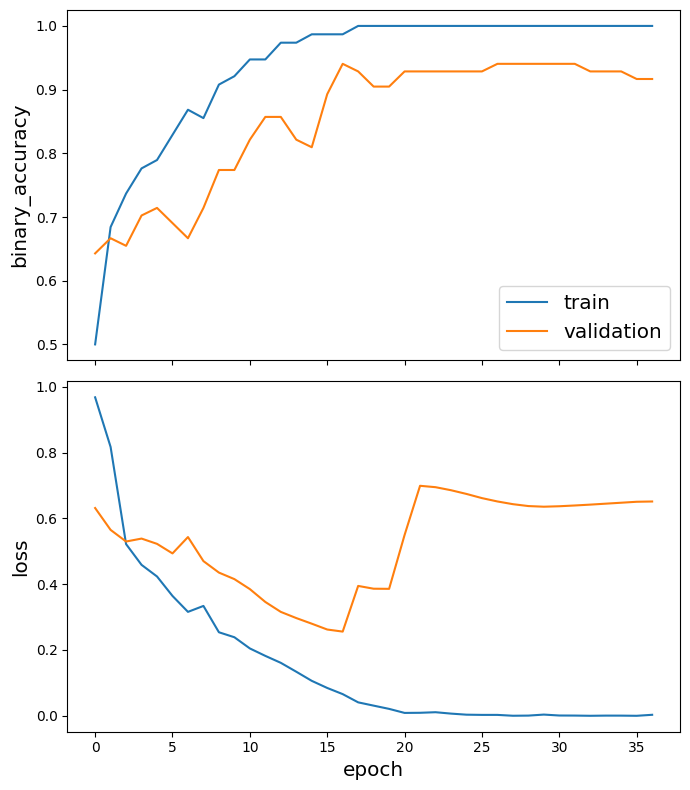

In [15]:
#학습 시에만 사용, 실행 시 모델이 재학습되기 때문에 평소에는 주석 처리

if TRAIN_MODE:
    model = build_compile(train_gen)
    fit_evaluate(model, train_flow, test_flow, model_name = model_path + file_name + '_embedding', epochs = 2000)
else:
    print('PASS')

In [16]:
model = build_compile(train_gen)
model.load_weights(model_path + file_name + '_embedding.h5')

pred_val = np.where(model.predict(test_flow).ravel() > 0.5, 1, 0)
acc = accuracy_score(edge_labels_test,pred_val)

print("\nValidation accuracy는 " + str(round(np.mean(acc),4))+ "입니다.\n")

embedding_model = keras.Model(inputs=model.input, outputs=model.layers[-5].output) #Node embedding
node_embeddings = embedding_model.predict(final_flow)[0]

df_embeddings = pd.DataFrame(node_embeddings, index = G.nodes())

1/1 [==============================] - 0s 150ms/step

Validation accuracy는 0.9405입니다.

1/1 [==============================] - 0s 100ms/step


In [17]:
df_embeddings

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
adjusted ebitda,-0.007083,-0.021975,0.002933,0.148581,0.032253,-0.022798,0.019550,0.141382,-0.000503,-0.007596,...,-0.019400,-0.005889,-0.031230,-0.025707,0.122596,-0.006829,0.006875,-0.009630,-0.011621,-0.024577
adr growth,-0.010738,0.015508,-0.009202,-0.005769,-0.003357,0.006485,-0.012200,-0.007538,0.016225,-0.004219,...,0.023615,-0.002167,-0.012309,-0.002822,-0.003223,-0.011039,-0.005249,-0.006137,-0.003124,-0.004620
ai,0.020829,0.040767,0.010717,-0.008736,-0.009036,0.069720,-0.006170,-0.017371,0.000773,-0.006729,...,0.018522,-0.002082,0.080412,-0.001947,-0.018466,-0.006182,0.067481,-0.016181,0.047283,0.037058
analytics,0.014547,0.014300,-0.014076,-0.005300,-0.006852,0.020472,-0.007623,-0.016658,0.025868,-0.015792,...,-0.001450,0.014099,0.032579,0.021515,-0.010459,-0.011586,0.000765,-0.011384,0.002019,0.037776
artificial intelligence,0.029768,0.049027,0.014484,-0.009871,-0.012383,0.066954,-0.008888,-0.018030,-0.003749,-0.007696,...,0.014852,-0.002657,0.092566,0.003476,-0.016732,-0.008130,0.060020,-0.016912,0.044550,0.049352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
valuation services,0.012795,0.011804,0.038325,0.031399,-0.003550,0.059988,-0.000547,-0.010163,-0.003264,-0.009753,...,-0.010802,0.047473,0.053687,-0.007531,-0.007039,0.010220,0.059796,-0.015757,0.046525,0.026213
weekday occupancy,-0.011265,0.018814,-0.019129,-0.012182,-0.004275,0.019462,-0.016249,-0.015515,0.030572,-0.007785,...,0.065511,0.006775,-0.010574,-0.008877,-0.003621,-0.012537,-0.008509,-0.014062,-0.008739,-0.002042
weekend occupancy,-0.012371,0.018992,-0.018904,-0.013401,-0.003770,0.019877,-0.016309,-0.016700,0.031604,-0.008057,...,0.070796,0.008133,-0.010823,-0.008838,-0.003507,-0.013933,-0.008351,-0.014883,-0.010210,-0.001265
wyndham,0.006334,0.035893,-0.008042,-0.000906,-0.005681,0.022587,-0.001785,0.007505,0.005670,-0.005852,...,0.003874,-0.001207,0.033613,0.007694,-0.019281,-0.005622,0.017357,-0.006714,0.014752,-0.009341


In [18]:
# 값이 1인 위치 찾기
row_idx_1, col_idx_1 = df.values.nonzero()

# 결과 출력
edge_index_1 = [[i, j] for i, j in zip(row_idx_1, col_idx_1)]
edge_index_1 = [[df.index[i], df.columns[j]] for i, j in edge_index_1]
edge_index_1 = torch.tensor([[df.index.get_loc(i), df.columns.get_loc(j)] for i, j in edge_index_1], dtype=torch.long)

In [19]:
edge_index_1.shape

torch.Size([850, 2])

In [20]:
data = Data(x= node_embeddings, edge_index= edge_index_1.t().contiguous())

transform = RandomLinkSplit(is_undirected=True, num_val= 0)
train_data, val_data, test_data = transform(data)

In [21]:
train_data

Data(x=[147, 1024], edge_index=[2, 680], edge_label=[680], edge_label_index=[2, 680])

# Train & Test split for ML

In [22]:
X_train = np.array([np.concatenate((train_data.x[train_data.edge_label_index[0][i].item()], train_data.x[train_data.edge_label_index[1][i].item()]), axis=0) 
                    for i in range(train_data.edge_label_index.shape[1])])
y_train = train_data.edge_label.numpy()

#X_val = np.array([np.concatenate((val_data.x[val_data.edge_label_index[0][i].item()], val_data.x[val_data.edge_label_index[1][i].item()]), axis=0) 
#                  for i in range(val_data.edge_label_index.shape[1])])
#y_val = val_data.edge_label.numpy()

X_test = np.array([np.concatenate((test_data.x[test_data.edge_label_index[0][i].item()], test_data.x[test_data.edge_label_index[1][i].item()]), axis=0) 
                   for i in range(test_data.edge_label_index.shape[1])])
y_test = test_data.edge_label.numpy()

X_test, y_test = shuffle(X_test, y_test, random_state=RANDOM_SEED)

# GridSearchCV

In [23]:
if TRAIN_MODE:
    pipe = Pipeline([('classifier',SVC())])
    param_grid = [
        {'classifier' : [SVC(probability=True)]},

        {'classifier' : [xgb.XGBClassifier(
            random_state = RANDOM_SEED, objective = 'binary:logistic', eval_metric = 'logloss', use_label_encoder = False)]},

        {'classifier' : [RandomForestClassifier(random_state = RANDOM_SEED)]}
    ]

    grid = GridSearchCV(pipe, param_grid=param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state = RANDOM_SEED), verbose=True)
    grid.fit(X_train, y_train)

    joblib.dump(grid, model_path + file_name + '_classifier.pkl')
else:
    print('PASS')

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [24]:
grid = joblib.load(model_path + file_name + '_classifier.pkl')

In [25]:
# 성능이 가장 좋은 세팅
grid.best_params_

{'classifier': SVC(probability=True)}

In [26]:
grid.best_score_

0.8985294117647058

In [27]:
y_pred = grid.predict(X_test)

print(grid.__class__.__name__, accuracy_score(y_test, y_pred))

GridSearchCV 0.9


# Output

In [28]:
# 값이 0인 위치 찾기
row_idx_0, col_idx_0 = (df == 0).values.nonzero()

# 결과 출력
edge_index_0 = [[i, j] for i, j in zip(row_idx_0, col_idx_0)]
edge_index_0 = [[df.index[i], df.columns[j]] for i, j in edge_index_0]
edge_index_0 = torch.tensor([[df.index.get_loc(i), df.columns.get_loc(j)] for i, j in edge_index_0 
                             if df.index.get_loc(i) != df.columns.get_loc(j)], dtype=torch.long)

In [29]:
X_0 = np.array([np.concatenate((train_data.x[edge_index_0[i][0].item()], train_data.x[edge_index_0[i][1].item()]), axis=0) 
                    for i in range(edge_index_0.shape[0])])

y_prob = grid.predict_proba(X_0)
y_final = [1 if prob[1] > prob[0] else 0 for prob in y_prob]

In [30]:
final  = pd.DataFrame(G.nodes()[edge_index_0], columns = ['Source', 'Target'])
final['prob'] = y_prob[:,1]
final = final.sort_values(by=['Source','Target']).reset_index(drop=True)
final

,Source,Target,prob
0,adjusted ebitda,adr growth,0.025278
1,adjusted ebitda,ai,0.006300
2,adjusted ebitda,analytics,0.013146
3,adjusted ebitda,artificial intelligence,0.006690
4,adjusted ebitda,average daily rate (adr),0.025356
...,...,...,...
20607,yoy,u.s. hotel performance,0.554148
20608,yoy,user experience,0.200666
20609,yoy,valuation,0.041840
20610,yoy,valuation services,0.035854


In [31]:
temp = final.sort_values(by=['Target','Source']).reset_index(drop=True)
temp

,Source,Target,prob
0,adr growth,adjusted ebitda,0.007537
1,ai,adjusted ebitda,0.005389
2,analytics,adjusted ebitda,0.008199
3,artificial intelligence,adjusted ebitda,0.005869
4,average daily rate (adr),adjusted ebitda,0.007592
...,...,...,...
20607,u.s. hotel performance,yoy,0.230444
20608,user experience,yoy,0.100643
20609,valuation,yoy,0.019108
20610,valuation services,yoy,0.034906


In [32]:
final['prob'] = (final['prob'] + temp['prob'] )/2

#idx = np.where(np.array(edge_index_0)[:, 0] > np.array(edge_index_0)[:, 1])[0]
#final = final.iloc[idx].reset_index(drop=True)

In [33]:
num_edges = math.floor(G.number_of_edges()*0.05 + 0.5) #반올림(python에서 round를 사용할 경우, 짝수와 홀수의 값이 달라서 직접 만들어서 사용)print(num_edges)

print("링크 예측 전 네트워크 전체 엣지의 5%는 " + str(num_edges) + "입니다.")

final = final.sort_values(by = ['prob'], ascending = False).reset_index(drop=True).iloc[:2*(num_edges-1)]
final['Node pair'] = [i for i in zip(final['Source'], final['Target'])]

링크 예측 전 네트워크 전체 엣지의 5%는 21입니다.


In [34]:
final

,Source,Target,prob,Node pair
0,occupancy growth,room demand,0.987335,"(occupancy growth, room demand)"
1,room demand,occupancy growth,0.987335,"(room demand, occupancy growth)"
2,real estate investment trust,cash flow,0.984114,"(real estate investment trust, cash flow)"
3,cash flow,real estate investment trust,0.984114,"(cash flow, real estate investment trust)"
4,pm,hospitality technology,0.972310,"(pm, hospitality technology)"
5,hospitality technology,pm,0.972310,"(hospitality technology, pm)"
6,dividend,debt,0.972191,"(dividend, debt)"
7,debt,dividend,0.972191,"(debt, dividend)"
8,integration,property management system,0.971873,"(integration, property management system)"
9,property management system,integration,0.971873,"(property management system, integration)"


In [35]:
ord_list = Counter(final['Source'].to_list() + final['Target'].to_list()).most_common()

In [36]:
link_pred = pd.DataFrame()

for keyword, _ in ord_list:
    link_pred = pd.concat([link_pred, (final[final['Node pair'].map(str).str.contains(keyword)]['Node pair'].map(lambda x : (x[1],x[0]) if keyword != x[0] else x))])

In [37]:
link_pred = link_pred.loc[~link_pred.index.duplicated(keep='first')]
link_pred = link_pred.drop_duplicates().reset_index(drop=True)
link_pred.index=link_pred.index+1
link_pred.rename(columns = {0:'Link'},inplace=True)

In [38]:
link_pred['Source'] = link_pred['Link'].map(lambda x: x[0])
link_pred['Target'] = link_pred['Link'].map(lambda x: x[1])

link_pred = link_pred[['Source', 'Target']]

In [39]:
#새로 추가된 Edge는 weight 5로 설정
aft.add_edges_from(list(zip(link_pred['Source'], link_pred['Target'])), weight = 5)

# #Edge에 동시 출현 문서 추가
# for edge in aft.edges:
#     aft.edges[edge]['co-occur_doc'] = str(set(ast.literal_eval(aft.nodes[edge[0]]['document_number_list'])) & set(ast.literal_eval(aft.nodes[edge[1]]['document_number_list'])))

In [40]:
result = (list(zip(link_pred['Source'], link_pred['Target'])))
new_result = []

for i in result:
    if (i[1],i[0]) not in new_result:
        new_result.append(i)

In [41]:
link_pred = pd.DataFrame(new_result, columns = ['Source', 'Target'])

In [42]:
final

,Source,Target,prob,Node pair
0,occupancy growth,room demand,0.987335,"(occupancy growth, room demand)"
1,room demand,occupancy growth,0.987335,"(room demand, occupancy growth)"
2,real estate investment trust,cash flow,0.984114,"(real estate investment trust, cash flow)"
3,cash flow,real estate investment trust,0.984114,"(cash flow, real estate investment trust)"
4,pm,hospitality technology,0.972310,"(pm, hospitality technology)"
5,hospitality technology,pm,0.972310,"(hospitality technology, pm)"
6,dividend,debt,0.972191,"(dividend, debt)"
7,debt,dividend,0.972191,"(debt, dividend)"
8,integration,property management system,0.971873,"(integration, property management system)"
9,property management system,integration,0.971873,"(property management system, integration)"


In [43]:
link_pred = pd.merge(link_pred, final[['Source','Target','prob']])

In [44]:
nx.write_gexf(aft, 
              path.replace('network_construction', 'visualize').replace(file_name, file_name + '_p'))

In [45]:
'''
result = pd.DataFrame()

result['Source'] = link_pred['Source']
result['Target'] = link_pred['Target']
result['Type'] = "Undirected"
result['Id'] = None
result['Label'] = None
result['timeset'] = None
result['Weight'] = 1

result.to_csv(path.replace('network_construction', 'link_pred').replace(file_name + '.gexf', 'new_link_'+ file_name +'.csv'),index= False, encoding = 'utf8') #Gephi input으로 사용
'''


link_pred = link_pred.groupby(['Source','Target'], sort=False).sum()
link_pred.to_csv(path.replace('network_construction', 'link_pred').replace(file_name + '.gexf', 'link_pred_'+ file_name +'.csv'), encoding = 'cp949') #결과 확인하기 위해 사용

In [46]:
len(link_pred)

20

In [47]:
link_pred

prob
Source                       Target                                
debt                         dividend                      0.972191
                             financial results             0.971614
                             real estate investment trust  0.971266
                             cash flow                     0.966639
cash and cash equivalents    portfolio management          0.966242
portfolio                    cash and cash equivalents     0.965760
net income                   portfolio management          0.965691
portfolio                    net income                    0.965247
                             ebitda                        0.964851
occupancy growth             room demand                   0.987335
                             market occupancy              0.965606
real estate investment trust cash flow                     0.984114
benchmarking                 data analytics                0.969542
                             commercial real estate        0.966731
service                      hvs principals                0.968897
                             global assignments            0.968897
new york city                global performance            0.967496
                             weekday occupancy             0.966538
pm                           hospitality technology        0.972310
integration                  property management system    0.971873

In [48]:
len(aft.edges())

445

In [49]:
len(bef.edges())

425